# 1 The Problem

We are using the [Consumer Reviews of Amazon Products](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products) dataset to analyze sentiments/ratings based on the words used in the product review.

In [ ]:
import pandas as pd
import math

import numpy as np
np.random.seed(7) # seeding random number generator

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid") # Plotting style

import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 Load Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/amazon-product-review/1429_1.csv"
df = pd.read_csv(dataset_path)
df1 = df
df1.head()
# df.info()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter,NaN,NaN,NaN
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman,NaN,NaN,NaN
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,NaN,NaN,NaN
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks,NaN,NaN,NaN
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42,NaN,NaN,NaN


In [ ]:
data = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,1.0,34131.000000,34627.000000
mean,111372787.0,0.630248,4.584573
std,NaN,13.215775,0.735653
min,111372787.0,0.000000,1.000000
25%,111372787.0,0.000000,4.000000
50%,111372787.0,0.000000,5.000000
75%,111372787.0,0.000000,5.000000
max,111372787.0,814.000000,5.000000


Text(0, 0.5, 'Count')

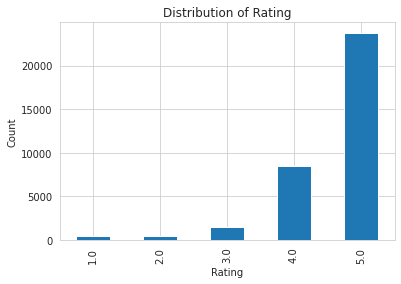

In [ ]:
df['reviews.rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

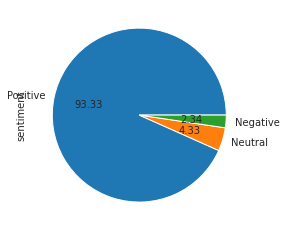

In [ ]:
def sentiment(rating):
    if rating == 5 or rating == 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif rating == 2 or rating == 1:
        return "Negative"
df["sentiment"] = df['reviews.rating'].apply(sentiment)       
df['sentiment'].value_counts().plot.pie(autopct='%.2f')

**Handling Imbalance Data**


<class 'pandas.core.frame.DataFrame'>
reviews.text      0
reviews.rating    0
dtype: int64


,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


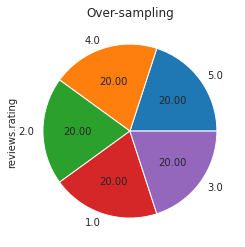

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="minority")
newdf = df1.drop(["id","name","asins","brand","categories","keys","manufacturer","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.didPurchase","reviews.doRecommend","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.title","reviews.userCity","reviews.userProvince","reviews.username"], axis='columns')
newdf = newdf.loc[:,~newdf.columns.str.contains('^Unnamed')]
newdf.dropna(subset = ["reviews.rating","reviews.text"], inplace=True)
# print(newdf.isnull().sum())
# print(newdf.isna().sum())
# newdf["reviews.rating"].value_counts().plot.pie(autopct='%.2f')

from imblearn.over_sampling import RandomOverSampler
X = newdf.drop(['reviews.rating'], axis=1)
y = newdf['reviews.rating']
# print(y.isna().sum())
#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_res, y_res = ros.fit_resample(X, y)
# print(X_res.head())
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")
y_res = pd.DataFrame(y_res)
print(type(y_res))
final = pd.concat([X_res, y_res], axis=1)
print(final.isnull().sum())
final.head()
# Final = 
# X_res.append(y_res)

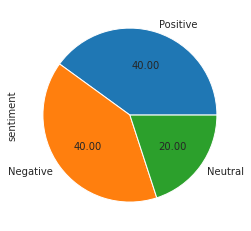

In [ ]:

# add sentiment to data
final["sentiment"] = final["reviews.rating"].apply(sentiment)
# test_set["sentiment"] = test_set["reviews.rating"].apply(sentiment)
# print(final["sentiment"][:10])
final['sentiment'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(final['reviews.text'],final['sentiment'])
print(y_train.value_counts())

Positive    35679
Negative    35655
Neutral     17818
Name: sentiment, dtype: int64


# 3 Split Train/Test Dataset

* Since the majority of reviews are postive (5 stars), we are going to do a 'stratified split' on the review score to ensure that the train dataset doesn't become imbalanced.
* We will use `Stratified ShuffleSplit` class from `sklearn`. To use it, we will remove all samples that have a `NaN` score, then convert all scores to `integer` datatype.

In [ ]:

print(len(x_train), len(y_train), len(x_test), len(y_test))
print(x_train.isna().sum(), y_train.isna().sum())
print(x_test.isna().sum(), y_test.isna().sum())

89152 89152 29718 29718
0 0
0 0


# 4 Feature Extraction

We will turn the review text into numerical features using the __Bag of Words__ strategy.
* We will assign fixed int id to each word occurance.
* We will also keep the frequency of each word occurred.

We will use `sklearn`'s `CountVectorizer` to accomplish the following:
* Tokenization
* Filtering stopwords such as 'the', are', etc.
* Occurence counting
* Feature vector

In [ ]:
# replace 'nan' in reviews.text with space
x_train = x_train.fillna(' ')
y_train = y_train.fillna(' ')
x_test = x_test.fillna(' ')
y_test = y_test.fillna(' ')

In [ ]:
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

Positive    0.400204
Negative    0.399935
Neutral     0.199861
Name: sentiment, dtype: float64
Negative    0.400195
Positive    0.399388
Neutral     0.200417
Name: sentiment, dtype: float64


In [ ]:
# text processing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train)
print(x_train_counts.shape)

(89152, 12770)


With longer documents, we typically see higher average count values on words that carry very little meaning. This is bad since it overshadows shorter documents.

We will use `sklearn`'s `TfidfTransformer` to reduce this redundancy.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
x_train_tfidf = transformer.fit_transform(x_train_counts)
print(x_train_tfidf.shape)

(89152, 12770)


# 5 Build Pipeline, Train, Test

We will primarily use **Multinomial Naive Bayes** as our classifier since it is most suitable for word counts where data are typically represented as **word vector counts**.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
#
multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])

In [ ]:
# train
multiNB_pipe.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])

In [ ]:
# train accuracy
y_train_pred = multiNB_pipe.predict(x_train)
print(f"Train Accuracy {np.mean(y_train_pred == y_train)}")

Train Accuracy 0.8463410804020101


In [ ]:
# test
y_pred = multiNB_pipe.predict(x_test)
print(f"Accuracy {np.mean(y_pred == y_test)}")

Accuracy 0.8425533346793189


In [ ]:
print(pd.core.series.Series(y_pred).value_counts() / len(y_pred))


Negative    0.452689
Positive    0.438960
Neutral     0.108352
dtype: float64


##For Performance Metrics##


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.95      0.90     11893
     Neutral       0.91      0.49      0.64      5956
    Positive       0.83      0.91      0.86     11869

    accuracy                           0.84     29718
   macro avg       0.86      0.78      0.80     29718
weighted avg       0.85      0.84      0.83     29718



# 6 Testing other models

**Logistic Regression Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
logReg_pipe.fit(x_train, y_train)

# train accuracy
y_train_pred = logReg_pipe.predict(x_train)
print(f"Train Accuracy {np.mean(y_train_pred == y_train)}")

y_pred = logReg_pipe.predict(x_test)
np.mean(y_pred == y_test)

Train Accuracy 0.9367821249102656


0.9254996971532404

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97     11893
     Neutral       0.87      0.83      0.85      5956
    Positive       0.93      0.90      0.91     11869

    accuracy                           0.93     29718
   macro avg       0.92      0.91      0.91     29718
weighted avg       0.92      0.93      0.92     29718



**Support Vector Machine**

In [ ]:
from sklearn.svm import LinearSVC
svc_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
svc_pipe.fit(x_train, y_train)

# train accuracy
y_train_pred = svc_pipe.predict(x_train)
print(f"Train Accuracy {np.mean(y_train_pred == y_train)}")
# print(x_test)
y_pred = svc_pipe.predict(x_test)
np.mean(y_pred == y_test)

Train Accuracy 0.9628163137114142


0.9516118177535501

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
text = ['very bad ','so bad','worst','exellent product','its okay but not as I expected']
print(svc_pipe.predict(text))

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99     11893
     Neutral       0.89      0.92      0.91      5956
    Positive       0.96      0.92      0.94     11869

    accuracy                           0.95     29718
   macro avg       0.94      0.95      0.94     29718
weighted avg       0.95      0.95      0.95     29718

['Positive' 'Positive' 'Negative' 'Positive' 'Negative']


***Using LSTM ***



In [ ]:
!pip install torch
!pip install transformers
# from torch import transformers
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 36.4 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
classifier(["We are very happy to show you the 🤗 Transformers library.","this product is okay but not as i expected","this product is barely okay","not so good","i will not recommend it"])

[{'label': 'POSITIVE', 'score': 0.9997795224189758},
 {'label': 'POSITIVE', 'score': 0.9462400078773499},
 {'label': 'NEGATIVE', 'score': 0.9997537732124329},
 {'label': 'NEGATIVE', 'score': 0.9997714161872864},
 {'label': 'NEGATIVE', 'score': 0.9946812987327576}]

In [ ]:
final['sentiment'].value_counts()

Positive    47548
Negative    47548
Neutral     23774
Name: sentiment, dtype: int64

In [ ]:
sentiment_labels = ['Positive','Neutral','Negative']
prediction = []
sequence = final['reviews.text'].tolist()
print(len(sequence))
results = classifier(sequence,sentiment_labels,truncation=True)
for result in results:
  prediction.append(result['label'])
prediction = pd.Series(prediction)  
prediction.value_counts() 
i = 0  
for predict in prediction:
  if final['sentiment'][i] == 'Positive':
    final['sentiment'][i] = 'POSITIVE'
  elif final['sentiment'][i] == 'Negative':
    final['sentiment'][i] = 'NEGATIVE'
  else:
    if predict == 'NEGATIVE':
      final['sentiment'][i] = 'NEGATIVE'
    else:
      final['sentiment'][i] = 'POSITIVE'
  i = i+1
print(classification_report(final['sentiment'][:len(prediction)],prediction))

Ignoring args : (['Positive', 'Neutral', 'Negative'],)


118870
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.91      0.90     62665
    POSITIVE       0.89      0.87      0.88     56205

    accuracy                           0.89    118870
   macro avg       0.89      0.89      0.89    118870
weighted avg       0.89      0.89      0.89    118870



              precision    recall  f1-score   support

    NEGATIVE       0.89      0.91      0.90     62665
    POSITIVE       0.89      0.87      0.88     56205

    accuracy                           0.89    118870
   macro avg       0.89      0.89      0.89    118870
weighted avg       0.89      0.89      0.89    118870

NEGATIVE    64157
POSITIVE    54713
dtype: int64


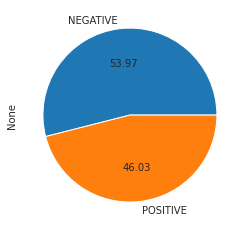

In [ ]:
print(classification_report(final['sentiment'][:len(prediction)],prediction))
print(prediction.value_counts())
prediction.value_counts().plot.pie(autopct='%.2f')